<a href="https://colab.research.google.com/github/Tessellate-Imaging/Monk_Object_Detection/blob/master/example_notebooks/4_efficientdet/Example%20-%20LISA%20Traffic%20Sign%20Recognition%20(Multi-GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

 - Run these commands
     
     - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git
     
     - cd Monk_Object_Detection/4_efficientdet/installation
     
 - Select the right requirements file and run
 
     - cat requirements.txt | xargs -n 1 -L 1 pip install

In [ ]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

# For Local systems and cloud select the right CUDA version
#! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

# About the network

1. Paper on EfficientDet: https://arxiv.org/abs/1911.09070

2. Blog 1 on EfficientDet: https://towardsdatascience.com/efficientdet-scalable-and-efficient-object-detection-review-4472ffc34fd9

3. Blog 2 on EfficientDet: https://medium.com/@nainaakash012/efficientdet-scalable-and-efficient-object-detection-ea05ccd28427

## Download the dataset

    Credits: http://cvrr.ucsd.edu/LISA/lisa-traffic-sign-dataset.html
    
 - Download the zip file from the link above
 - Unzip in the same parent directory as the jupyter notebook
 

# Current Format

## Dataset Directory Structure

    signDatabasePublicFramesOnly (root)
          |
          |
          |------------aiua120214-0
                          |
                          |--------------frameAnnotations-DataLog02142012_external_camera.avi_annotations
                                                          |
                                                          |-------------img1.jpg
                                                          |-------------img2.jpg
          |------------aiua120214-1
                          |
                          |--------------frameAnnotations-DataLog02142012_001_external_camera.avi_annotations
                                                          |
                                                          |-------------img1.jpg
                                                          |-------------img2.jpg
          |------------allAnnotations.csv

# Required COCO Format - 2

## Dataset Directory Structure

         ./ (root_dir)
          |
          |------signDatabasePublicFramesOnly (coco_dir) 
                          |
                          |--aiua120214-0
                              |
                              |------frameAnnotations-DataLog02142012_external_camera.avi_annotations
                                                              |
                                                              |-------------img1.jpg
                                                              |-------------img2.jpg
                          |---aiua120214-1
                              |
                              |--------------frameAnnotations-DataLog02142012_001_external_camera.avi_annotations
                                                              |
                                                              |-------------img1.jpg
                                                              |-------------img2.jpg
                          |
                          |
                          |
                          |---annotations 
                              |
                              |--------------------instances_.json  (instances_<set_dir>.json)
                              |--------------------classes.txt
          
          
 - instances_.json -> In proper COCO format
 - classes.txt          -> A list of classes in alphabetical order
 
 For TrainSet
 - root_dir = "./";
 - coco_dir = "signDatabasePublicFramesOnly";
 - img_dir = "";
 - set_dir = "";

 
 Note: Annotation file name too coincides against the set_dir (and set_dir is blank)

# Current format to Monk Format

In [1]:
import os
import sys
import pandas as pd
import numpy
from PIL import Image

In [26]:
df = pd.read_csv("signDatabasePublicFramesOnly/allAnnotations.csv", delimiter=";");

In [27]:
len(df)

7855

In [29]:
columns = df.columns
columns

Index(['Filename', 'Annotation tag', 'Upper left corner X',
       'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y',
       'Occluded,On another road', 'Origin file', 'Origin frame number',
       'Origin track', 'Origin track frame number'],
      dtype='object')

In [43]:
current_name = "aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image0.png"
wr = "";
combined = [];
for i in range(len(df)):
    fname = df["Filename"][i];
    label = str(df["Annotation tag"][i]);
    x1 = str(df["Upper left corner X"][i]);
    y1 = str(df["Upper left corner Y"][i]);
    x2 = str(df["Lower right corner X"][i]);
    y2 = str(df["Lower right corner Y"][i]);
    
    if(fname == current_name):
        wr += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label + " ";
    else:
        wr = wr[:-1]
        combined.append([current_name, wr]);
        current_name = fname
        wr = "";
        wr += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label + " ";

In [44]:
len(combined)

6617

In [46]:
out_df = pd.DataFrame(combined, columns = ['ID', 'Label']);
out_df.to_csv("signDatabasePublicFramesOnly/train_labels.csv", index=False)

# Monk Format to COCO Format

In [51]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

In [52]:
root = "signDatabasePublicFramesOnly/";
img_dir = "";
anno_file = "train_labels.csv";

In [53]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

In [54]:
if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

In [55]:
output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

In [56]:
if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

In [57]:
df = pd.read_csv(input_annotations_path);
columns = df.columns

In [58]:
delimiter = " ";

In [59]:
list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

100%|██████████| 47/47 [00:00<00:00, 84970.81it/s]


In [60]:
coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    if(not os.path.isfile(image_in_path)):
        continue;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

100%|██████████| 6617/6617 [01:25<00:00, 77.09it/s] 


# Training

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [2]:
from train_detector import Detector

In [3]:
gtf = Detector();

In [4]:
root_dir = "./";
coco_dir = "signDatabasePublicFramesOnly";
img_dir = "";
set_dir = "";

In [5]:
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=16, image_size=512, use_gpu=True)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [6]:
gtf.Model(gpu_devices=[0, 1, 2, 3]);

Loaded pretrained weights for efficientnet-b0


In [7]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [8]:
gtf.Train(num_epochs=50, model_output_dir="trained/");

../../4_efficientdet/lib/src/model.py:251: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(inputs) == 2:
../../4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
../../4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the 

# Inference - Post 50 epochs

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [2]:
from infer_detector import Infer

../../4_efficientdet/lib/infer_detector.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
gtf = Infer();

In [4]:
gtf.Model(model_dir="trained/")

/home/abhi/.virtualenvs/monk_obj_4_efficientdet/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/abhi/.virtualenvs/monk_obj_4_efficientdet/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
f = open("signDatabasePublicFramesOnly/annotations/classes.txt", 'r');
class_list = f.readlines();
f.close();
for i in range(len(class_list)):
    class_list[i] = class_list[i][:-1]

In [7]:
print(class_list)

['addedLane', 'curveLeft', 'curveRight', 'dip', 'doNotEnter', 'doNotPass', 'intersection', 'keepRight', 'laneEnds', 'merge', 'noLeftTurn', 'noRightTurn', 'pedestrianCrossing', 'rampSpeedAdvisory20', 'rampSpeedAdvisory35', 'rampSpeedAdvisory40', 'rampSpeedAdvisory45', 'rampSpeedAdvisory50', 'rampSpeedAdvisoryUrdbl', 'rightLaneMustTurn', 'roundabout', 'school', 'schoolSpeedLimit25', 'signalAhead', 'slow', 'speedLimit15', 'speedLimit25', 'speedLimit30', 'speedLimit35', 'speedLimit40', 'speedLimit45', 'speedLimit50', 'speedLimit55', 'speedLimit65', 'speedLimitUrdbl', 'stop', 'stopAhead', 'thruMergeLeft', 'thruMergeRight', 'thruTrafficMergeLeft', 'truckSpeedLimit55', 'turnLeft', 'turnRight', 'yield', 'yieldAhead', 'zoneAhead25', 'zoneAhead45']


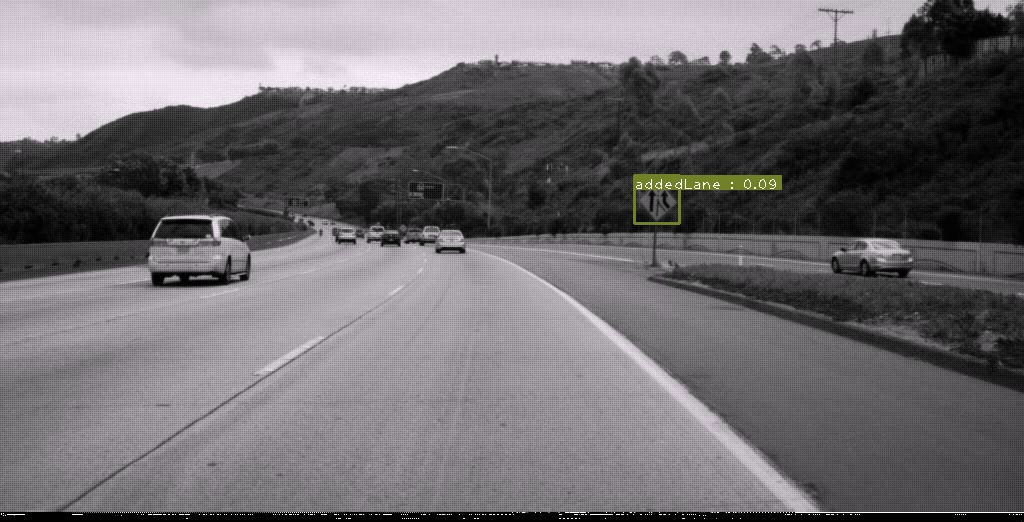

In [10]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img1.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.01);
from IPython.display import Image
Image(filename='output.jpg') 

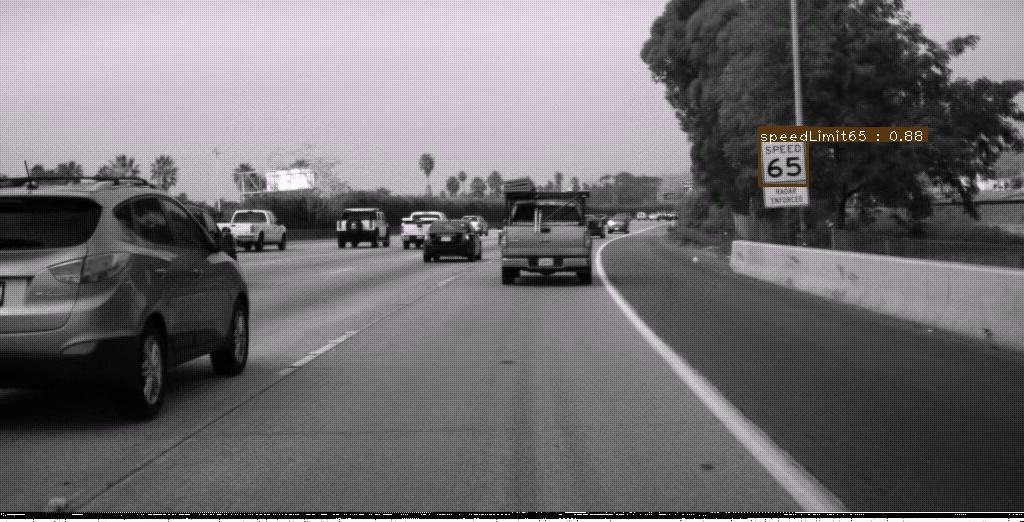

In [18]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img2.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.5);
from IPython.display import Image
Image(filename='output.jpg') 

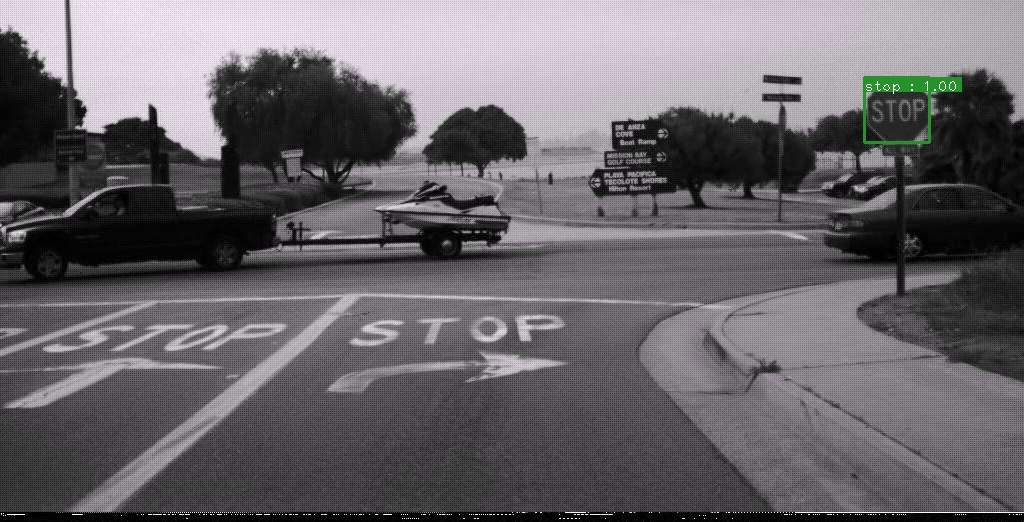

In [19]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img3.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.5);
from IPython.display import Image
Image(filename='output.jpg') 

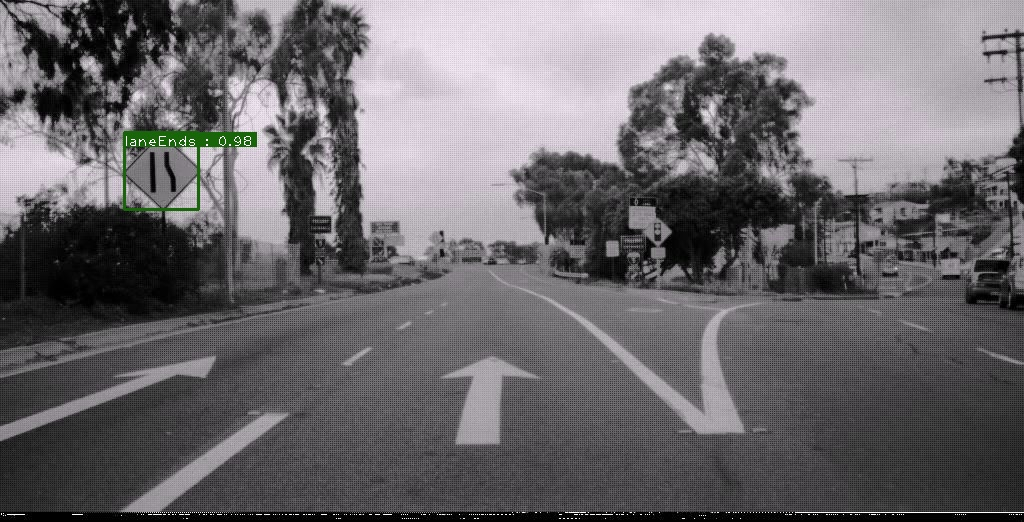

In [23]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img5.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.1);
from IPython.display import Image
Image(filename='output.jpg') 

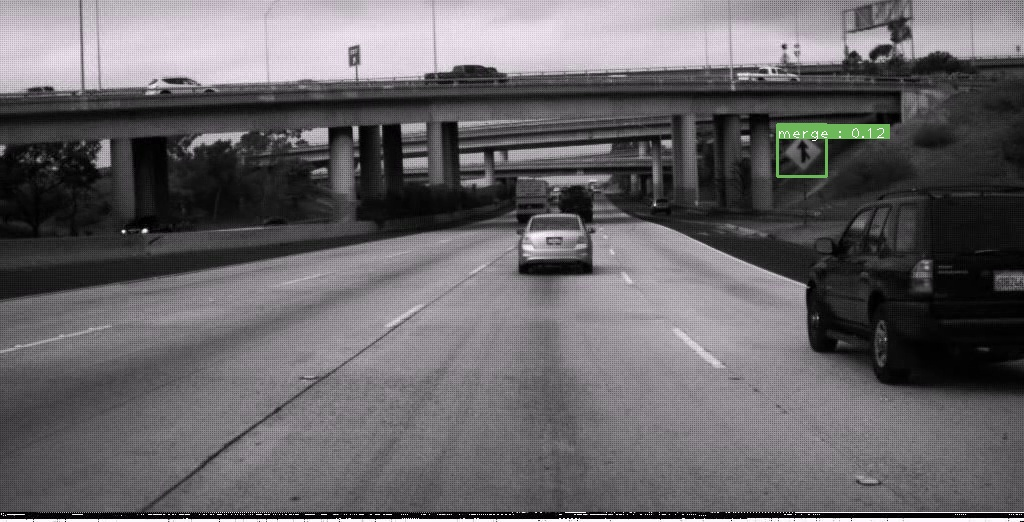

In [25]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img6.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.1);
from IPython.display import Image
Image(filename='output.jpg') 

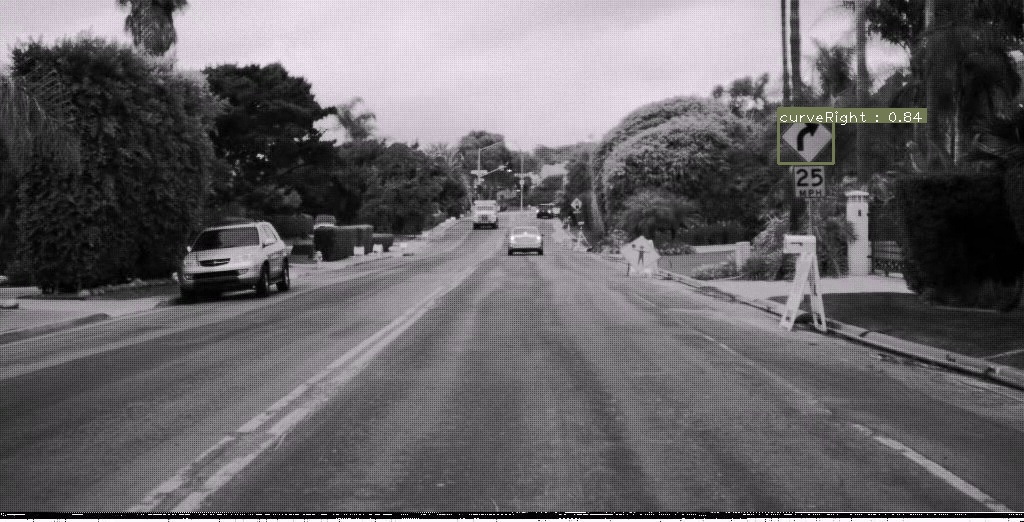

In [29]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img7.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.01);
from IPython.display import Image
Image(filename='output.jpg') 

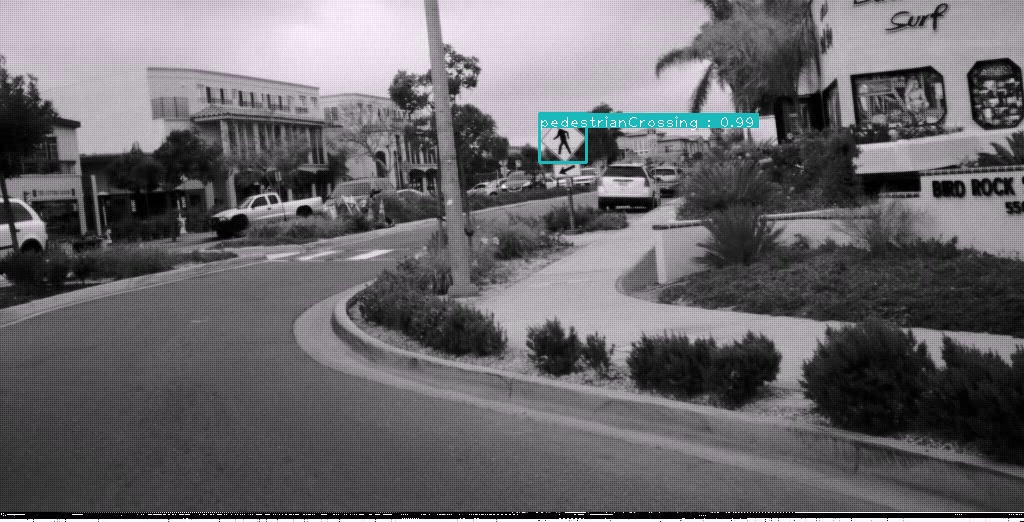

In [33]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img8.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.4);
from IPython.display import Image
Image(filename='output.jpg') 

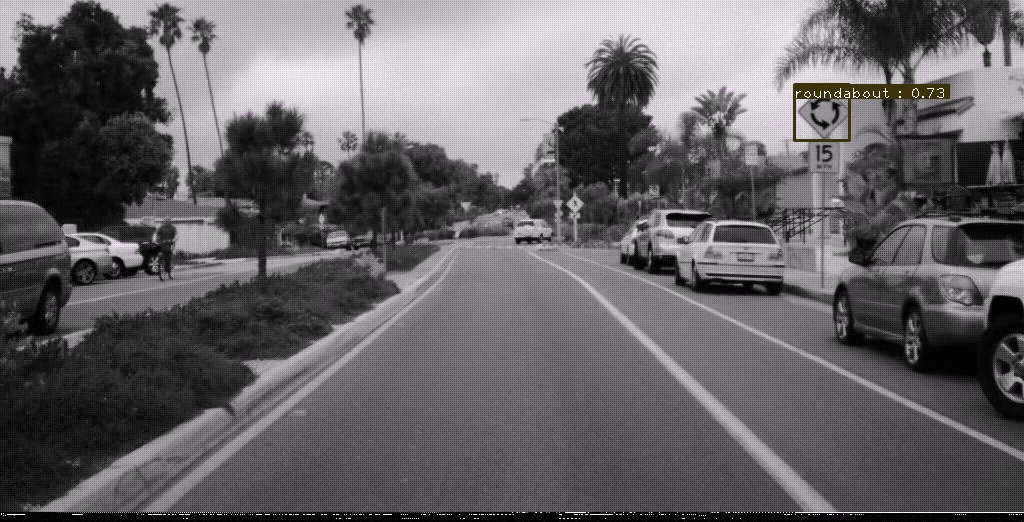

In [43]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img9.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.1);
from IPython.display import Image
Image(filename='output.jpg') 

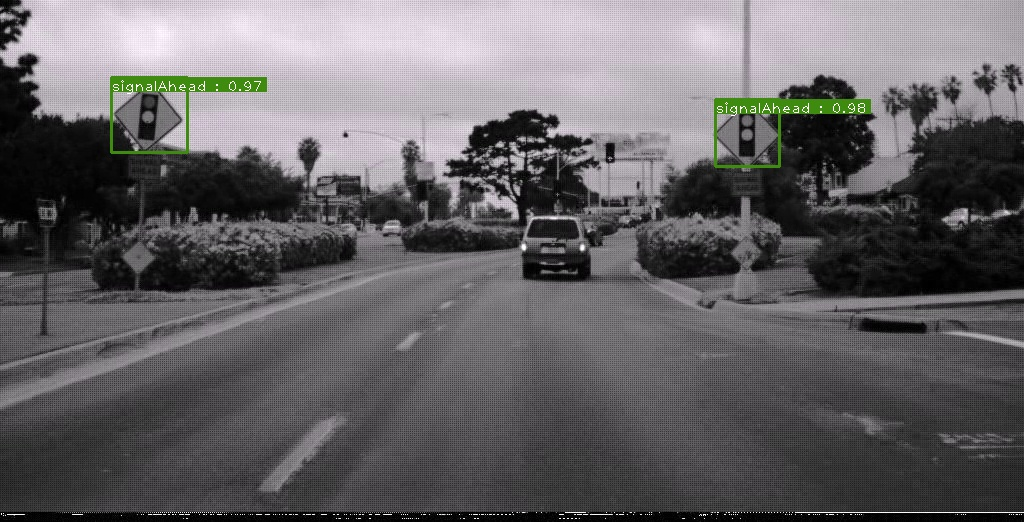

In [45]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img10.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.1);
from IPython.display import Image
Image(filename='output.jpg') 

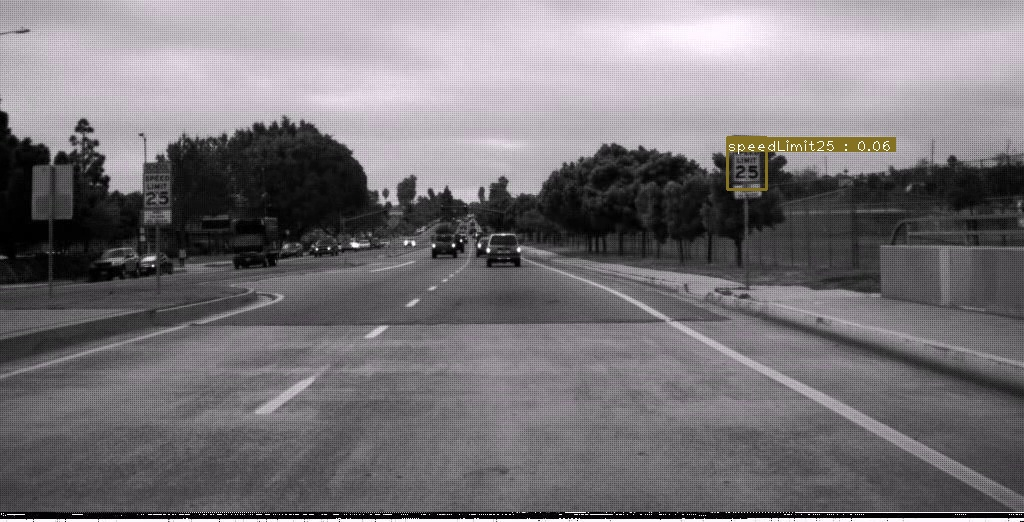

In [51]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img11.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.01);
from IPython.display import Image
Image(filename='output.jpg') 

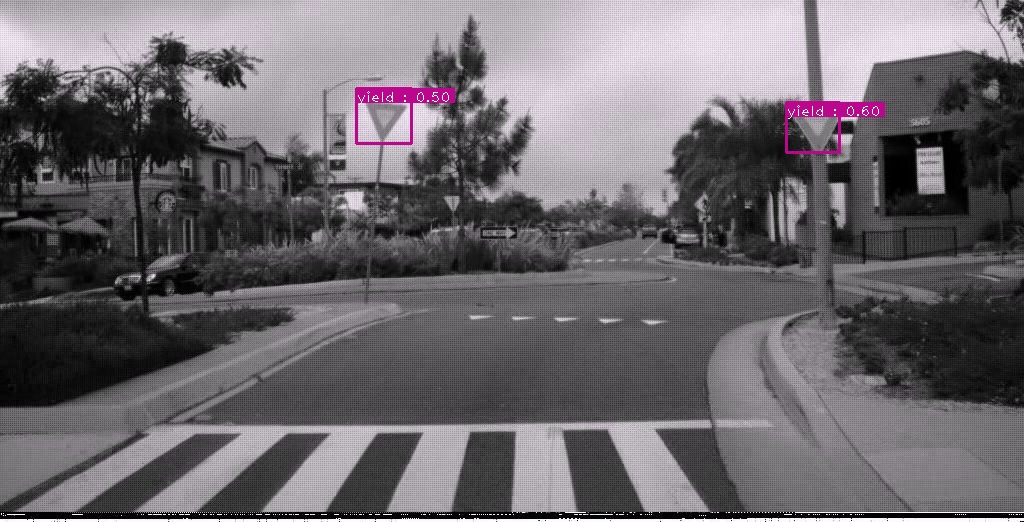

In [53]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img12.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.3);
from IPython.display import Image
Image(filename='output.jpg')

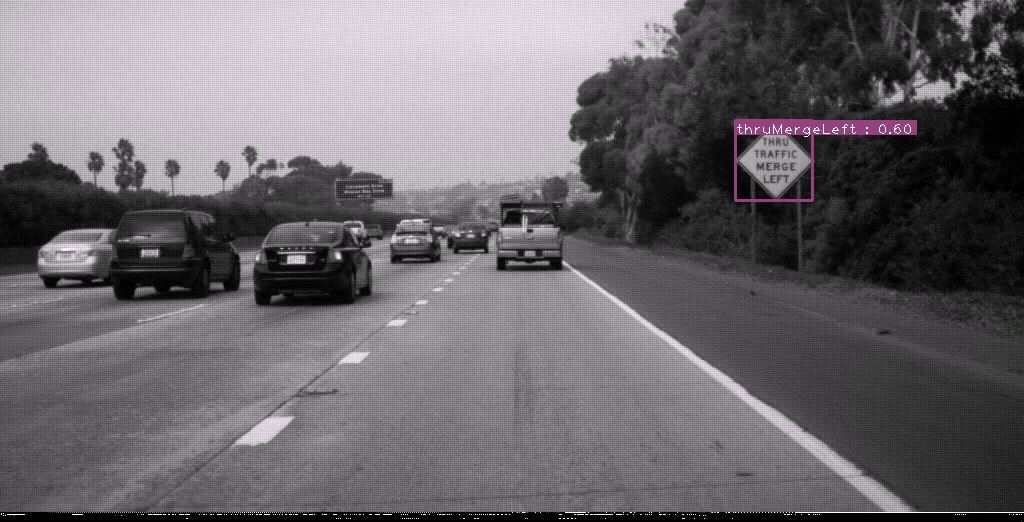

In [54]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img13.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.3);
from IPython.display import Image
Image(filename='output.jpg')

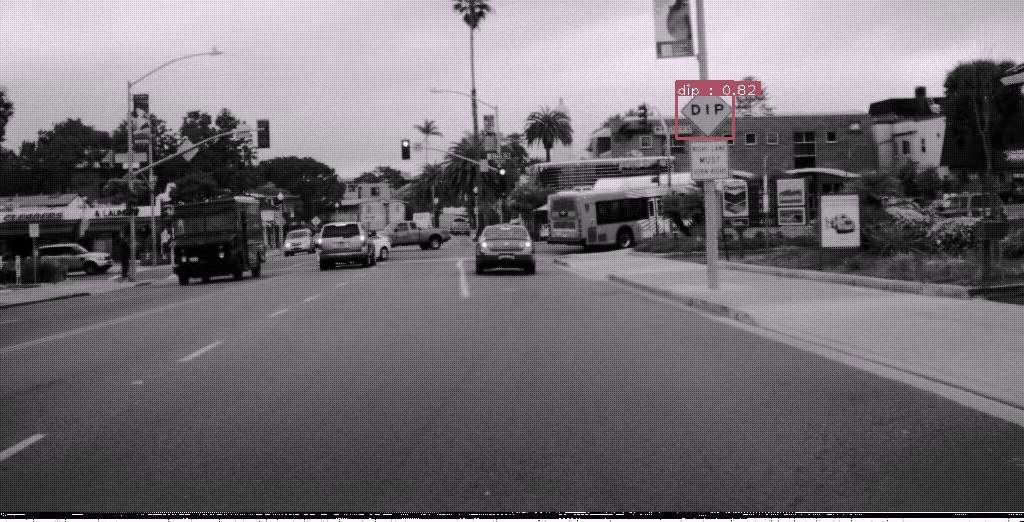

In [61]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img14.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.01);
from IPython.display import Image
Image(filename='output.jpg')

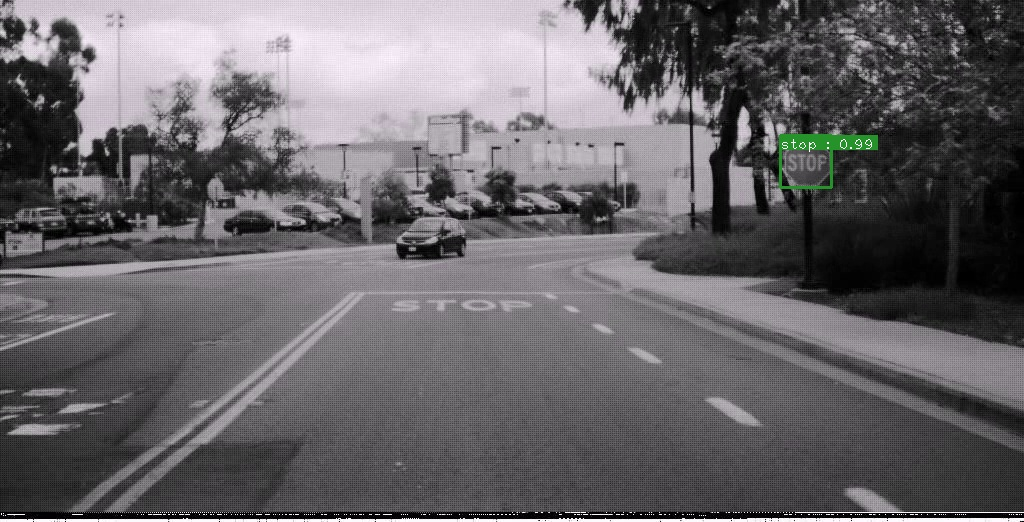

In [63]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img15.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.01);
from IPython.display import Image
Image(filename='output.jpg')

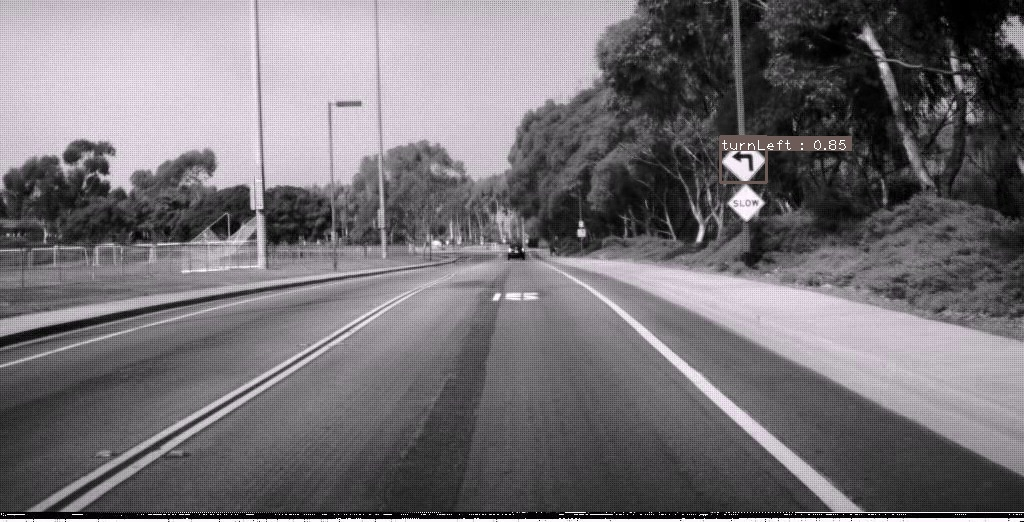

In [70]:
img_path = "Monk_Object_Detection/example_notebooks/sample_dataset/lisa_traffic_sign_test/img16.png";
scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.4);
from IPython.display import Image
Image(filename='output.jpg')